# BITS F464: Machine Learning — Assignment 1 (Prahlad MV)

**Prahlad MV** 2022AATS2022H



## 1) Setup in Colab + Import & Read Data (Requesting to run my assignement submission on Colab as sometimes some of the outputs "may" not show in VS code due to version compatabilities. Just as a backup this notebook will be uploaded in my Gihub  )

In [55]:
#Q1,2

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os

# Try to use local file; if not found, prompting upload in Colab
DATA_PATH = "housing.csv"

if not os.path.exists(DATA_PATH):
    try:
        from google.colab import files
        print("'housing.csv' not found. Please upload it now...")
        uploaded = files.upload()   # will prompt for file
        if "housing.csv" in uploaded:
            DATA_PATH = "housing.csv"
    except ImportError:
        raise FileNotFoundError("housing.csv not found. Please place it in the same directory.")

# Pandas & plotting setup
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (8,5)

# Reading data
data = pd.read_csv(DATA_PATH)
print("Shape (rows, cols):", data.shape)
display(data.info())
display(data.head(10).style.set_caption("Head(10) of Data"))

Shape (rows, cols): (20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230000,37.880000,41,880,129.000000,322,126,8.325200,452600,NEAR BAY
1,-122.220000,37.860000,21,7099,1106.000000,2401,1138,8.301400,358500,NEAR BAY
2,-122.240000,37.850000,52,1467,190.000000,496,177,7.257400,352100,NEAR BAY
3,-122.250000,37.850000,52,1274,235.000000,558,219,5.643100,341300,NEAR BAY
4,-122.250000,37.850000,52,1627,280.000000,565,259,3.846200,342200,NEAR BAY
5,-122.250000,37.850000,52,919,213.000000,413,193,4.036800,269700,NEAR BAY
6,-122.250000,37.840000,52,2535,489.000000,1094,514,3.659100,299200,NEAR BAY
7,-122.250000,37.840000,52,3104,687.000000,1157,647,3.120000,241400,NEAR BAY
8,-122.260000,37.840000,42,2555,665.000000,1206,595,2.080400,226700,NEAR BAY
9,-122.250000,37.840000,52,3549,707.000000,1551,714,3.691200,261100,NEAR BAY


## 3) Descriptive Statistics (mean, median, std, etc.)

In [56]:
#Q3
desc = data.describe(include='all').T
num_cols = data.select_dtypes(include=np.number).columns
desc.loc[num_cols, 'median'] = data[num_cols].median()
display(desc.style.set_caption("Descriptive Statistics (with Median)"))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,median
longitude,20640.000000,nan,nan,nan,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000,-118.490000
latitude,20640.000000,nan,nan,nan,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000,34.260000
housing_median_age,20640.000000,nan,nan,nan,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000,29.000000
total_rooms,20640.000000,nan,nan,nan,2635.763081,2181.615252,2.000000,1447.750000,2127.000000,3148.000000,39320.000000,2127.000000
total_bedrooms,20433.000000,nan,nan,nan,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000,435.000000
population,20640.000000,nan,nan,nan,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000,1166.000000
households,20640.000000,nan,nan,nan,499.539680,382.329753,1.000000,280.000000,409.000000,605.000000,6082.000000,409.000000
median_income,20640.000000,nan,nan,nan,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100,3.534800
median_house_value,20640.000000,nan,nan,nan,206855.816909,115395.615874,14999.000000,119600.000000,179700.000000,264725.000000,500001.000000,179700.000000
ocean_proximity,20640,5,<1H OCEAN,9136,nan,nan,nan,nan,nan,nan,nan,nan


## 4) Visualize Descriptive Statistics (per numerical column)

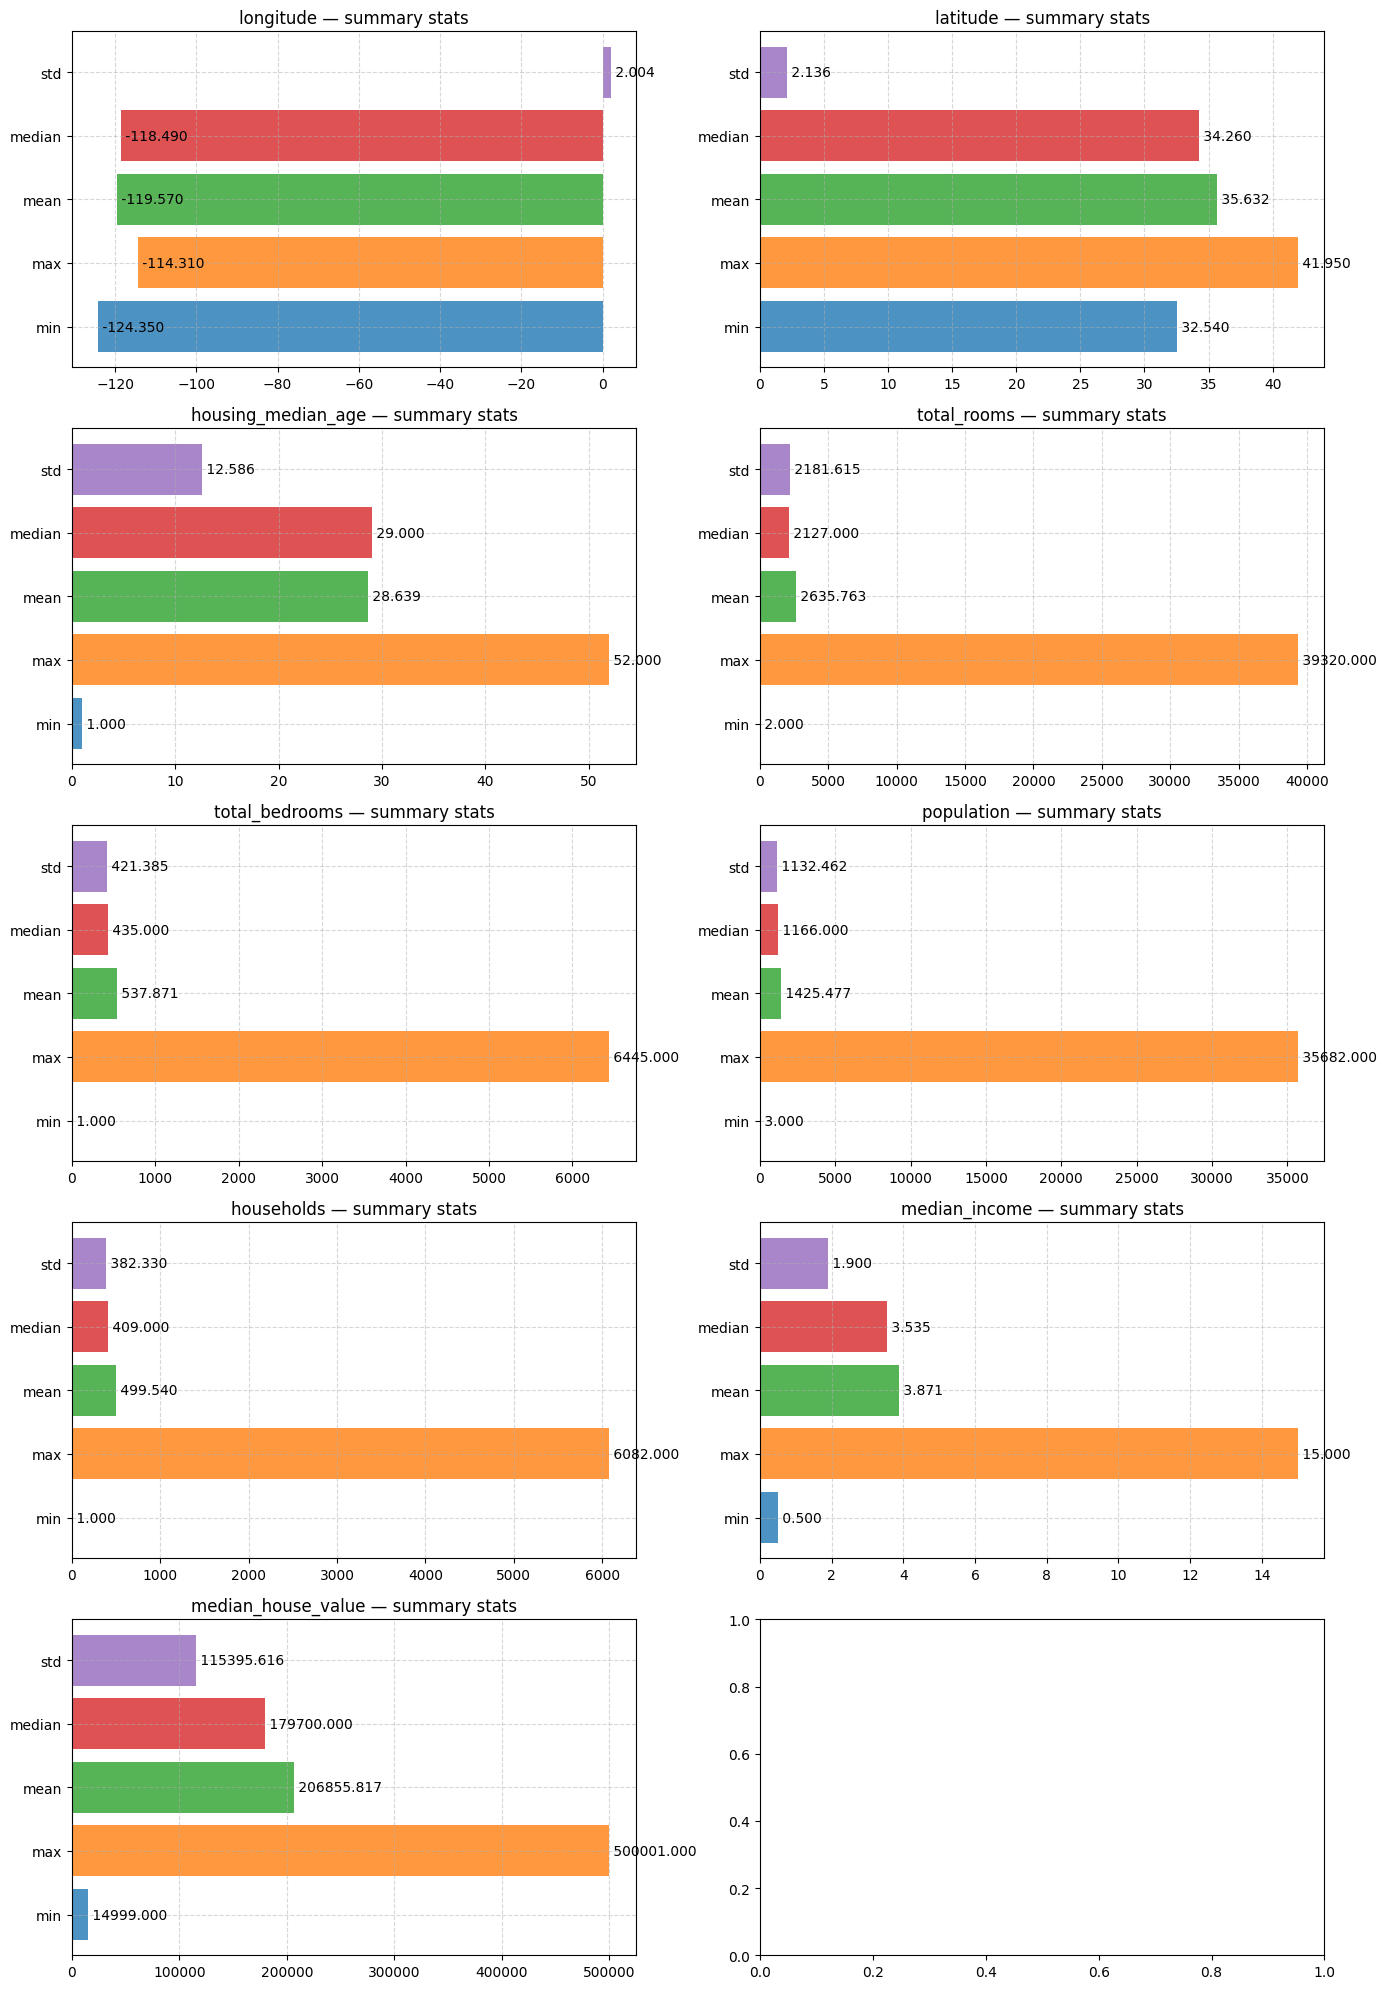

In [57]:
#Q4
def visualize_descriptive_stats(df):
    import numpy as np, matplotlib.pyplot as plt

    numeric_cols = df.select_dtypes(include=np.number).columns
    stats_to_show = ['min', 'max', 'mean', 'median', 'std']
    n = len(numeric_cols)
    rows = int(np.ceil(n / 2)); cols = 2 if n > 1 else 1
    fig, axes = plt.subplots(rows, cols, figsize=(14, rows*4))
    axes = np.array(axes).reshape(-1)

    # Picking a color palette
    colors = plt.cm.tab10.colors  # There are 10 distinct colors from Matplotlib color palette

    for i, col in enumerate(numeric_cols):
        series = df[col].dropna()
        vals = {
            'min': series.min(),
            'max': series.max(),
            'mean': series.mean(),
            'median': series.median(),
            'std': series.std()
        }
        ax = axes[i]
        names = list(vals.keys())
        values = list(vals.values())

        # using different colors for each bar
        bar_colors = [colors[j % len(colors)] for j in range(len(names))]
        ax.barh(names, values, color=bar_colors, alpha=0.8)

        ax.set_title(f"{col} — summary stats")
        ax.grid(True, linestyle='--', alpha=0.5)

        for j, v in enumerate(values):
            ax.text(v, j, f" {v:.3f}", va='center')

    plt.tight_layout()
    plt.show()

visualize_descriptive_stats(data)

## 5) Handling Missing Values

In [75]:
#Q5
import os, pandas as pd, numpy as np

RAW_PATH = DATA_PATH if 'DATA_PATH' in globals() else "housing.csv"

data_before_impute = pd.read_csv(RAW_PATH)

# Columns that truly had missing values before imputation
na_cols = data_before_impute.columns[data_before_impute.isna().any()].tolist()

print("#Before handling missing values")
s_before = data_before_impute.isnull().sum()
s_before.index.name = "Columns"
s_before.name = "No.of missing values"
print(s_before)

#Before handling missing values
Columns
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
Name: No.of missing values, dtype: int64


In [77]:
#Q5 continuation and Q6
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

if 'data' not in globals():
    data = pd.read_csv(RAW_PATH)

numeric_cols      = data.select_dtypes(include=np.number).columns.tolist()
categorical_cols  = data.select_dtypes(exclude=np.number).columns.tolist()

categorical_cols  = [c for c in categorical_cols if c != 'ocean_proximity_encoded']

# Deciding per-numeric strategy using the BEFORE snapshot
num_strategies = {}
for col in numeric_cols:
    if col in data_before_impute.columns:
        s = data_before_impute[col]
        num_strategies[col] = 'median' if s.std() > s.mean() else 'mean'
    else:
        s = data[col]
        num_strategies[col] = 'median' if s.std() > s.mean() else 'mean'

# Imputing numeric columns
for col, strat in num_strategies.items():
    data[[col]] = SimpleImputer(strategy=strat).fit_transform(data[[col]])

# Imputing categorical colums
if len(categorical_cols) > 0:
    data[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(data[categorical_cols])

print("Numeric strategies:", num_strategies)
print("Categorical strategy: most_frequent on", categorical_cols)

# Safe encoding
if 'ocean_proximity' not in data.columns:
    raise ValueError("Column 'ocean_proximity' not found. Load dataset and run Cell 1 first.")

le = LabelEncoder()
data['ocean_proximity_encoded'] = le.fit_transform(data['ocean_proximity'])
print("Created/updated 'ocean_proximity_encoded'. Mapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

Numeric strategies: {'longitude': 'median', 'latitude': 'mean', 'housing_median_age': 'mean', 'total_rooms': 'mean', 'total_bedrooms': 'mean', 'population': 'mean', 'households': 'mean', 'median_income': 'mean', 'median_house_value': 'mean', 'ocean_proximity_encoded': 'median', 'is_premium': 'median', 'cost_per_room': 'median'}
Categorical strategy: most_frequent on ['ocean_proximity']
Created/updated 'ocean_proximity_encoded'. Mapping:
{'<1H OCEAN': np.int64(0), 'INLAND': np.int64(1), 'ISLAND': np.int64(2), 'NEAR BAY': np.int64(3), 'NEAR OCEAN': np.int64(4)}


## 6) Plot Distribution Before vs After Imputation


#After handling missing values
Columns
longitude                  0
latitude                   0
housing_median_age         0
total_rooms                0
total_bedrooms             0
population                 0
households                 0
median_income              0
median_house_value         0
ocean_proximity            0
ocean_proximity_encoded    0
is_premium                 0
cost_per_room              0
Name: No.of missing values, dtype: int64


,column,na_count_before,na_count_after
0,total_bedrooms,207,0


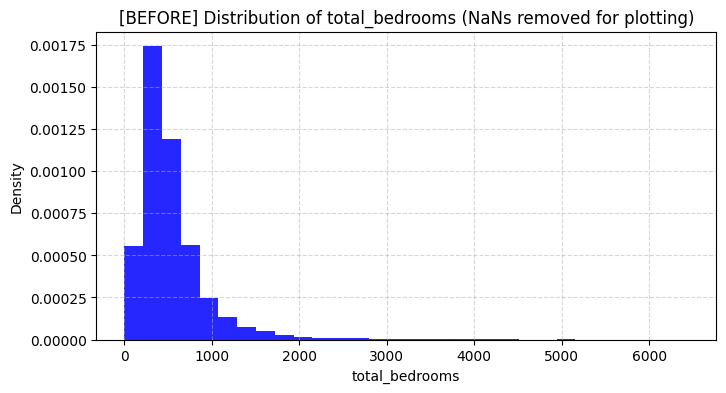

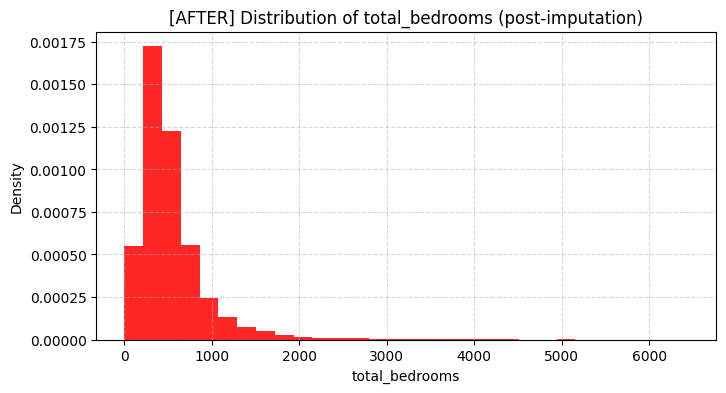

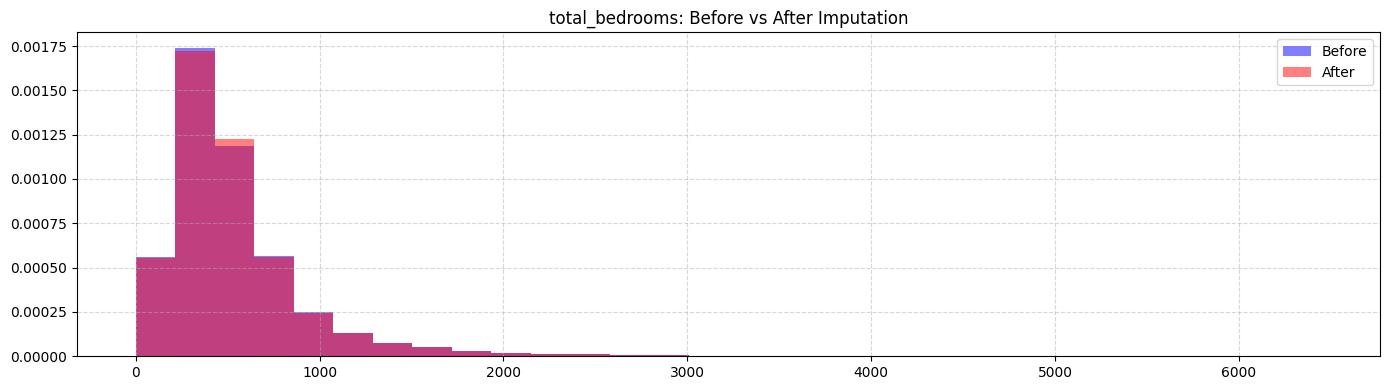

No Missing Values Guarantee: PASSED (all NaNs imputed)


In [80]:
#Q6
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# After counts
print("\n#After handling missing values")
s_after = data.isnull().sum()
s_after.index.name = "Columns"
s_after.name = "No.of missing values"
print(s_after)

# Quick table for NA columns, before vs after
cols_to_show = na_cols if len(na_cols) else []  # from BEFORE snapshot cell
na_report = pd.DataFrame({
    "column": cols_to_show,
    "na_count_before": [data_before_impute[c].isna().sum() for c in cols_to_show],
    "na_count_after":  [data[c].isna().sum()             for c in cols_to_show],
})
display(na_report.style.set_caption("Missing Value Counts — Before vs After"))

# Before only histograms, blue color
if len(cols_to_show) == 0:
    print("No columns had missing values (nothing to plot).")
else:
    for col in cols_to_show:
        plt.figure(figsize=(8, 4))
        plt.hist(data_before_impute[col].dropna(), bins=30, density=True, alpha=0.85, color='blue')
        plt.title(f"[BEFORE] Distribution of {col} (NaNs removed for plotting)")
        plt.xlabel(col); plt.ylabel("Density")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    # After only histograms, red color
    for col in cols_to_show:
        plt.figure(figsize=(8, 4))
        plt.hist(data[col].dropna(), bins=30, density=True, alpha=0.85, color='red')
        plt.title(f"[AFTER] Distribution of {col} (post-imputation)")
        plt.xlabel(col); plt.ylabel("Density")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    # Overlayof Before (blue) and After (red)
    rows = int(math.ceil(len(cols_to_show) / 2))
    fig, axes = plt.subplots(rows, 2 if len(cols_to_show) > 1 else 1, figsize=(14, rows * 4))
    axes = np.array(axes).reshape(-1)
    for i, col in enumerate(cols_to_show):
        ax = axes[i]
        b = data_before_impute[col].dropna()
        a = data[col].dropna()
        ax.hist(b, bins=30, density=True, alpha=0.5, label='Before', color='blue')
        ax.hist(a, bins=30, density=True, alpha=0.5, label='After', color='red')
        ax.set_title(f"{col}: Before vs After Imputation")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()
    plt.tight_layout(); plt.show()

remaining_na = int(data.isna().sum().sum())
assert remaining_na == 0, f"There are still {remaining_na} missing values after imputation."
print("No Missing Values Guarantee: PASSED (all NaNs imputed)")

## 7) Removing Duplicates

In [82]:
#Q7
before_rows, before_cols = data.shape

# Dropping duplicate rows
data = data.drop_duplicates()

after_rows, after_cols = data.shape

print(f"Removed {before_rows - after_rows} duplicate rows.")
print(f"Remaining rows: {after_rows}")
print(f"Final shape: {data.shape}")

# Explanation
print("\nNote:")
print(f"- The original housing.csv file had 10 columns.")
print(f"- Our dataset now has {after_cols} columns because we engineered extra features (e.g., 'premium', 'ocean_proximity_encoded').")
print("  Hence, seeing 13 columns here is expected and correct.")
print("- No duplicate rows were found, so the row count stayed at 20640.")


Removed 0 duplicate rows.
Remaining rows: 20640
Final shape: (20640, 13)

Note:
- The original housing.csv file had 10 columns.
- Our dataset now has 13 columns because we engineered extra features (e.g., 'premium', 'ocean_proximity_encoded').
  Hence, seeing 13 columns here is expected and correct.
- No duplicate rows were found, so the row count stayed at 20640.


## 8) Visualization — Scatter of Longitude vs Latitude (color by median_house_value)

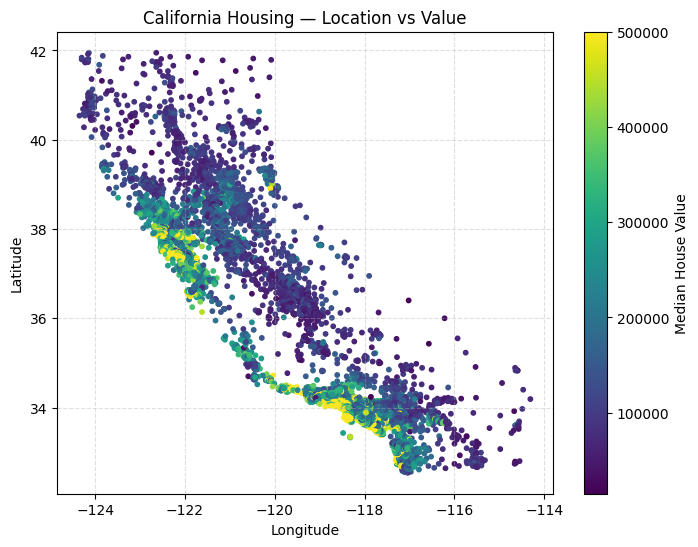

In [86]:
#Q8
if all(c in data.columns for c in ['longitude','latitude','median_house_value']):
    plt.figure(figsize=(8,6))
    sc = plt.scatter(data['longitude'], data['latitude'], c=data['median_house_value'], s=10)
    plt.colorbar(sc, label='Median House Value')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.title('California Housing — Location vs Value')
    plt.grid(True, linestyle='--', alpha=0.4); plt.show()
else:
    print("Required columns not present for the scatter plot.")

## 9) Observations — Counts & Plot

,metric,count
0,total_bedrooms < 1500,19986
1,median_income > 10,308
2,median_house_value >= 376600,2066


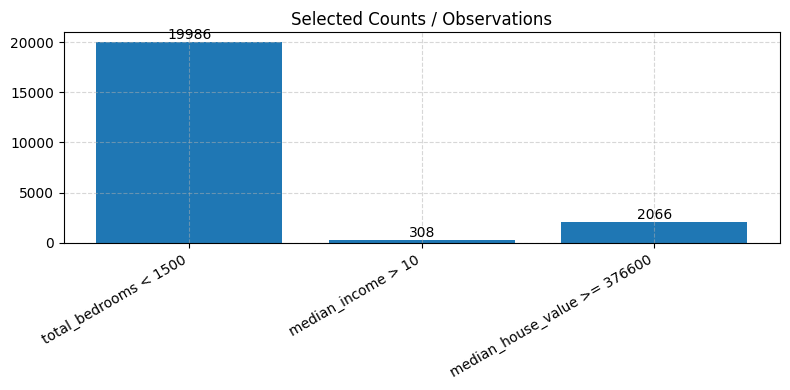

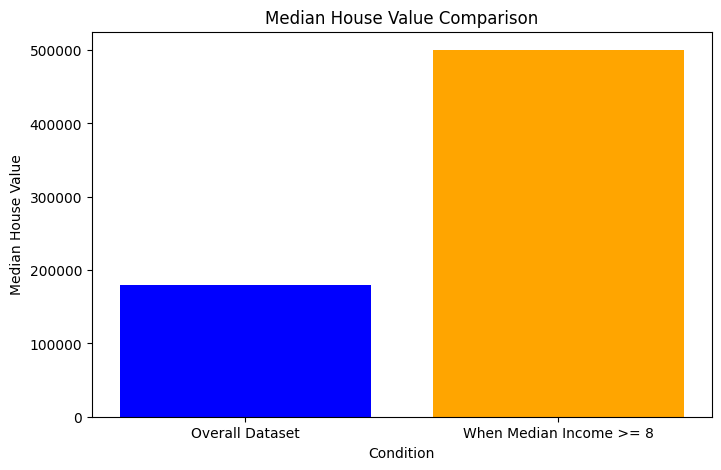

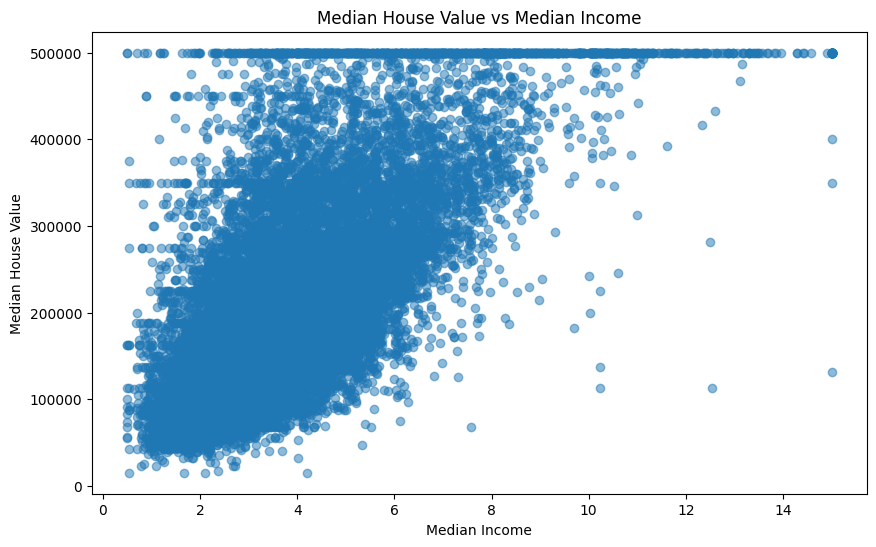

In [84]:
#Q9
obs_counts = {}
if 'total_bedrooms' in data.columns:
    obs_counts['total_bedrooms < 1500'] = int((data['total_bedrooms'] < 1500).sum())
if 'median_income' in data.columns:
    obs_counts['median_income > 10'] = int((data['median_income'] > 10).sum())
if 'median_house_value' in data.columns:
    th90 = float(data['median_house_value'].quantile(0.9))
    obs_counts[f'median_house_value >= {th90:.0f}'] = int((data['median_house_value'] >= th90).sum())

obs_df = pd.DataFrame({'metric': list(obs_counts.keys()), 'count': list(obs_counts.values())})
display(obs_df.style.set_caption("Observation Counts"))
plt.figure(figsize=(8,4))
plt.bar(obs_df['metric'], obs_df['count']); plt.xticks(rotation=30, ha='right')
plt.title('Selected Counts / Observations'); plt.grid(True, linestyle='--', alpha=0.5)
for i, v in enumerate(obs_df['count']): plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout(); plt.show()

#Obsn 1
median1=data[data.median_income>=8].median_house_value.median()
median2=data.median_house_value.median()
plt.bar(['Overall Dataset','When Median Income >= 8'],[median2,median1],color=['blue','orange'])
plt.title("Median House Value Comparison")
plt.xlabel("Condition")
plt.ylabel("Median House Value")
plt.show()

#Obsn 2
plt.figure(figsize=(10,6))
plt.plot(data.median_income, data.median_house_value, 'o', alpha=0.5)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Median House Value vs Median Income")
plt.show()

**Observation One:**
The median house value in the dataset is substantially lower in general, as compared to the values observed when the median income is greater than or equal to 8.

**Observation Two:**
Median house value is directly proportional to median income

## 10) Ocean Proximity — Grouping, Box Plots, Encoding

,house_price_mean,income_mean,rooms_mean
ocean_proximity,,,
<1H OCEAN,240084.29,4.23,2628.34
INLAND,124805.39,3.21,2717.74
ISLAND,380440.00,2.74,1574.60
NEAR BAY,259212.31,4.17,2493.59
NEAR OCEAN,249433.98,4.01,2583.70


['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


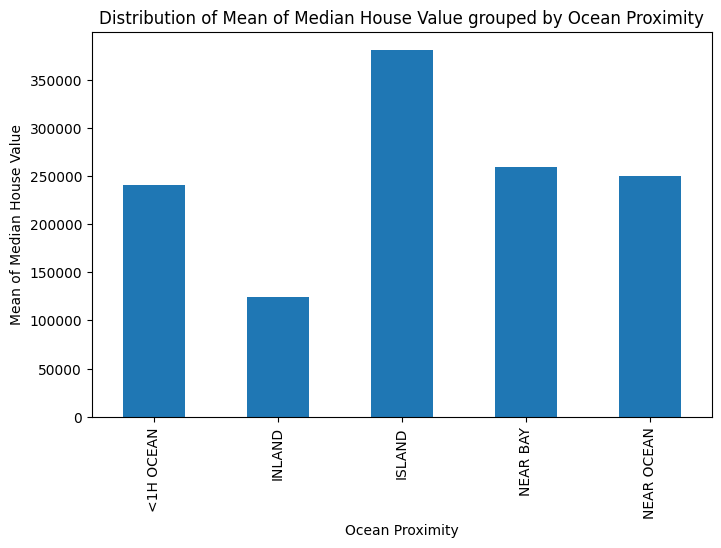

In [87]:
#Q10
grouped = (data.groupby("ocean_proximity")
           .agg(house_price_mean=("median_house_value","mean"),
                income_mean=("median_income","mean"),
                rooms_mean=("total_rooms","mean"))
           .round(2))
display(grouped)


le = LabelEncoder()
data["ocean_proximity"] = le.fit_transform(data["ocean_proximity"])
print(list(le.classes_))

ax = grouped.reset_index().plot(kind="bar", x="ocean_proximity", y="house_price_mean", legend=False)
ax.set_title("Distribution of Mean of Median House Value grouped by Ocean Proximity")
ax.set_xlabel("Ocean Proximity")
ax.set_ylabel("Mean of Median House Value")
plt.show()

/tmp/ipython-input-2282373443.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(series_list, labels=cats, vert=True)


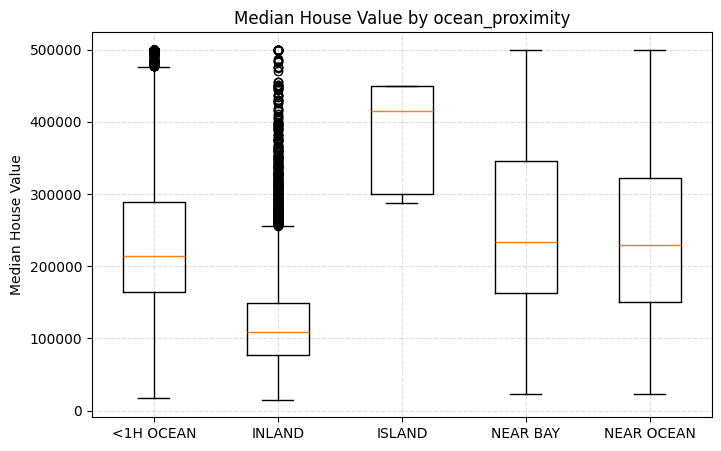

Label encoding mapping: {'<1H OCEAN': np.int64(0), 'INLAND': np.int64(1), 'ISLAND': np.int64(2), 'NEAR BAY': np.int64(3), 'NEAR OCEAN': np.int64(4)}


In [63]:
#Q10 extras
from sklearn.preprocessing import LabelEncoder

if 'ocean_proximity' in data.columns:
    grouped = data.groupby('ocean_proximity')
    summary_by_group = grouped.agg(['count','mean','median','std','min','max'])
    display(summary_by_group.style.set_caption("Summary by ocean_proximity"))
    # visualizing distribution of target across categories
    if 'median_house_value' in data.columns:
        plt.figure(figsize=(8,5))
        cats = list(grouped.groups.keys())
        series_list = [data.loc[data['ocean_proximity']==cat, 'median_house_value'].dropna() for cat in cats]
        plt.boxplot(series_list, labels=cats, vert=True)
        plt.title('Median House Value by ocean_proximity'); plt.ylabel('Median House Value')
        plt.grid(True, linestyle='--', alpha=0.4); plt.show()
    # encode categorical
    le = LabelEncoder()
    data['ocean_proximity_encoded'] = le.fit_transform(data['ocean_proximity'])
    print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
else:
    print("ocean_proximity column not found.")

## 11)

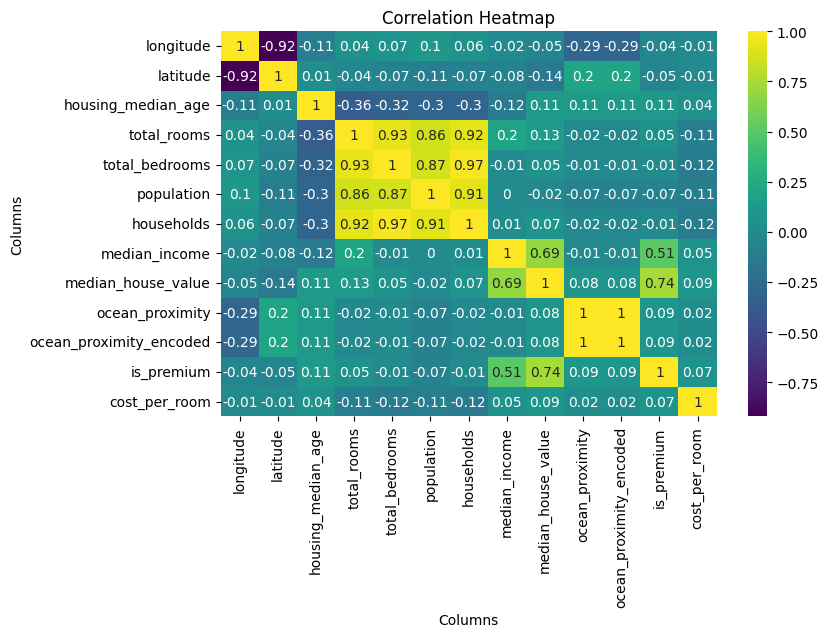

In [90]:
# Q11a, Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(data.corr().round(2), annot=True, cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


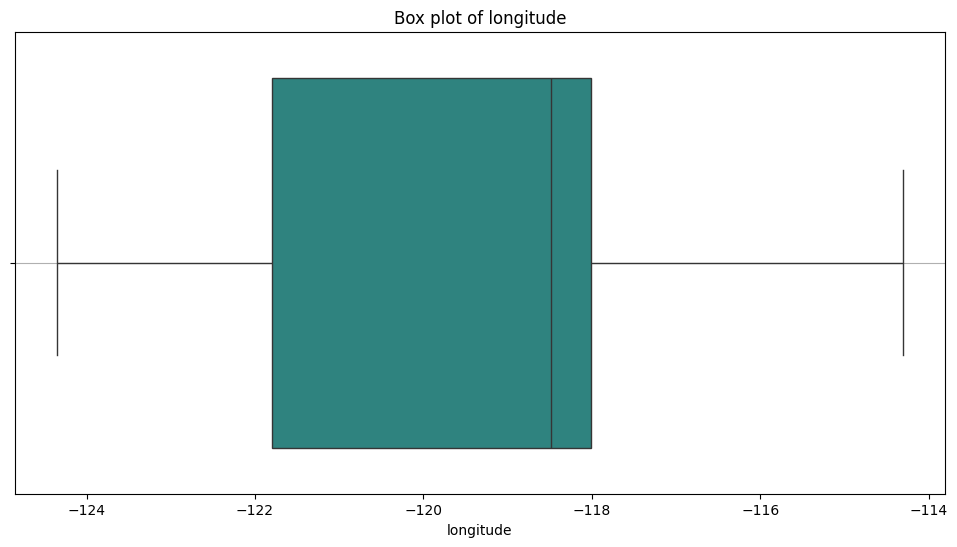

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


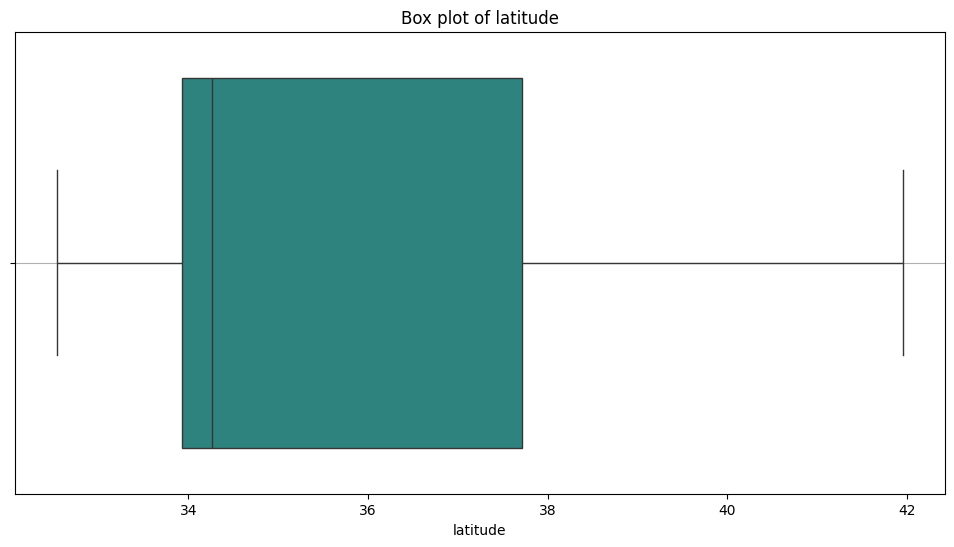

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


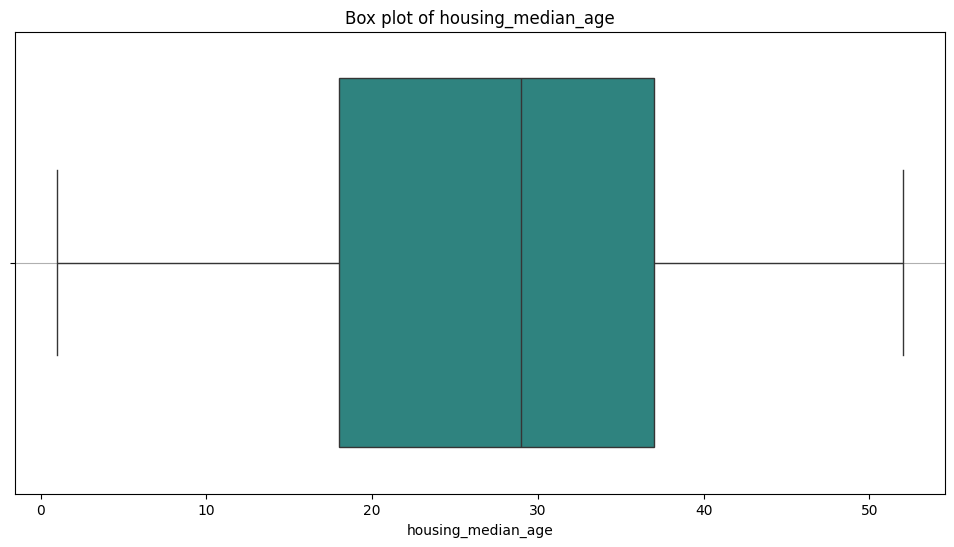

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


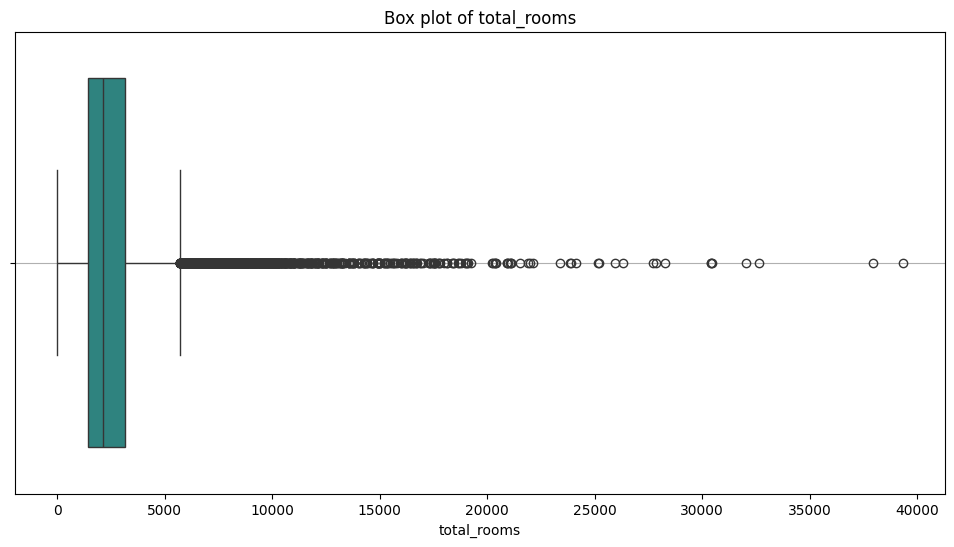

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


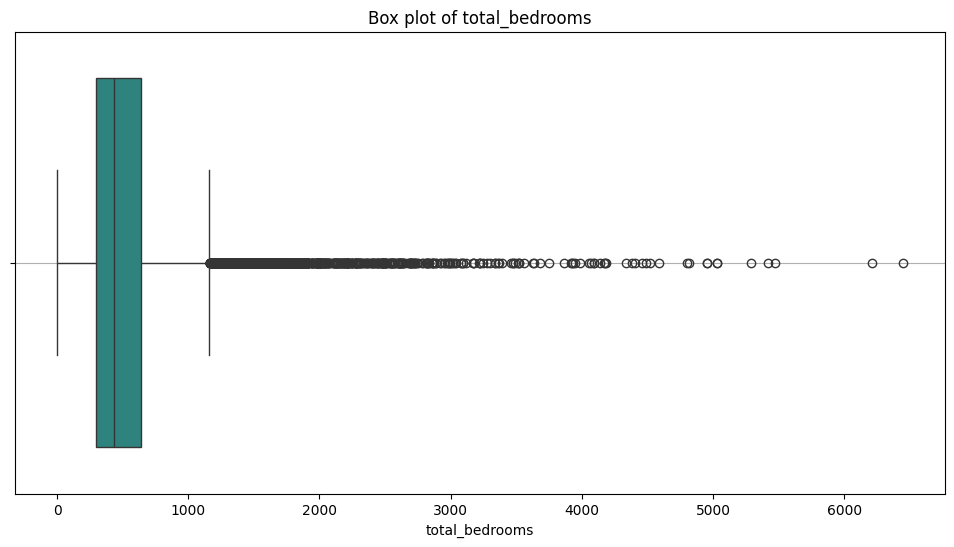

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


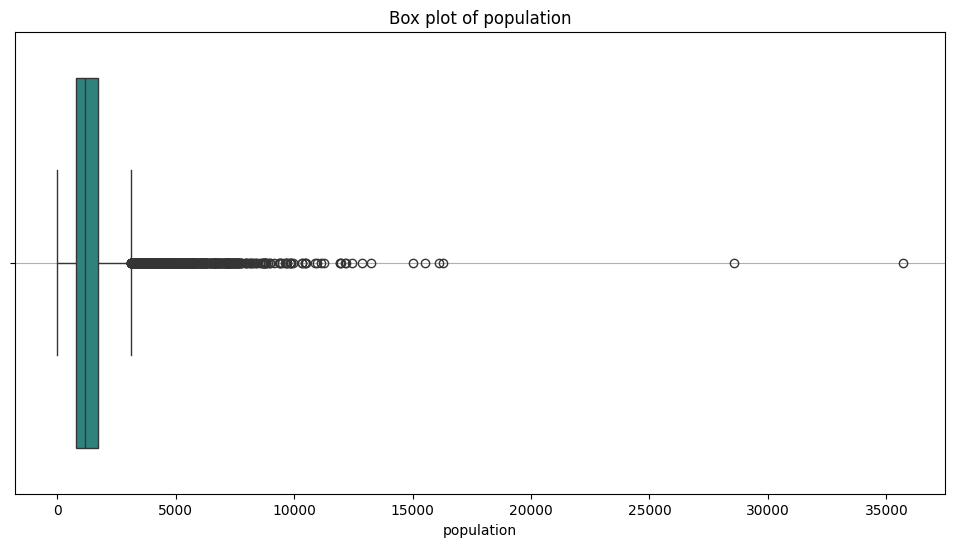

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


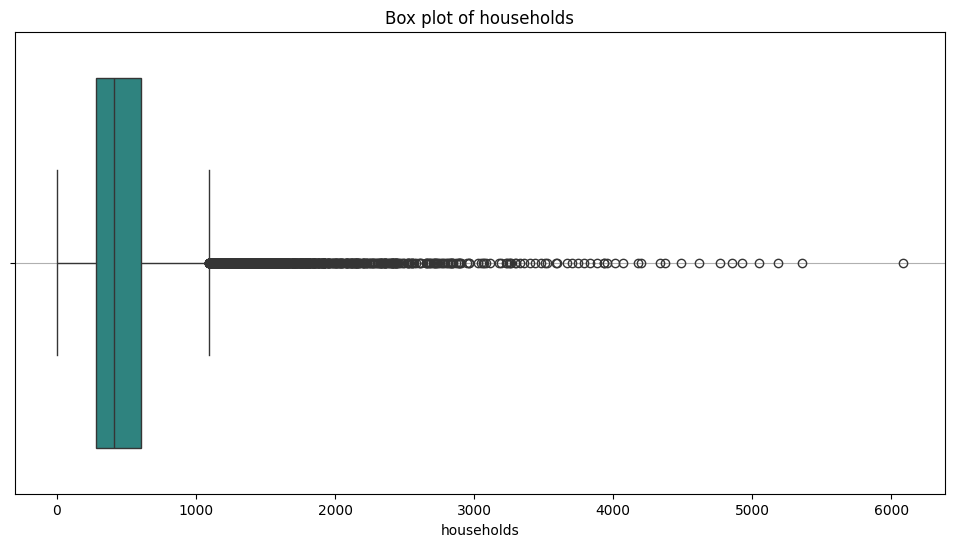

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


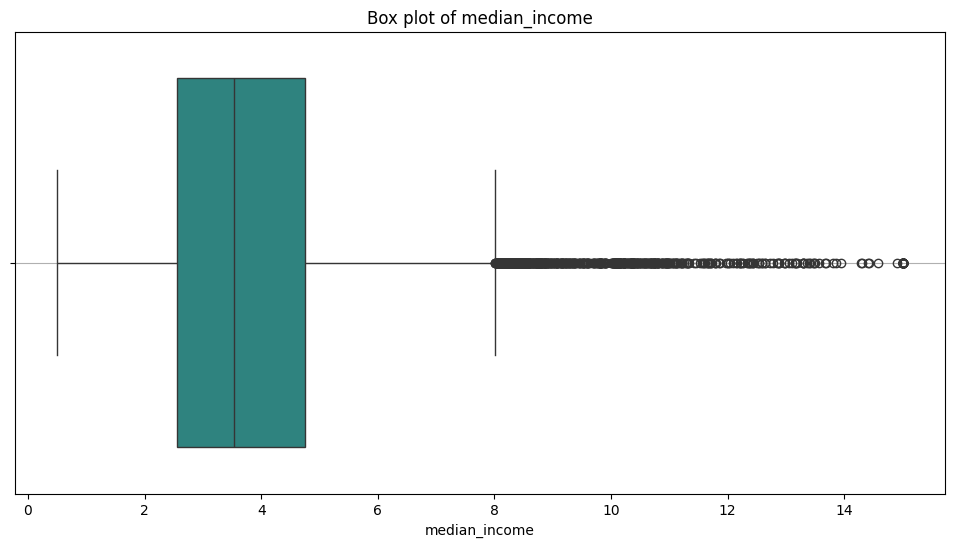

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


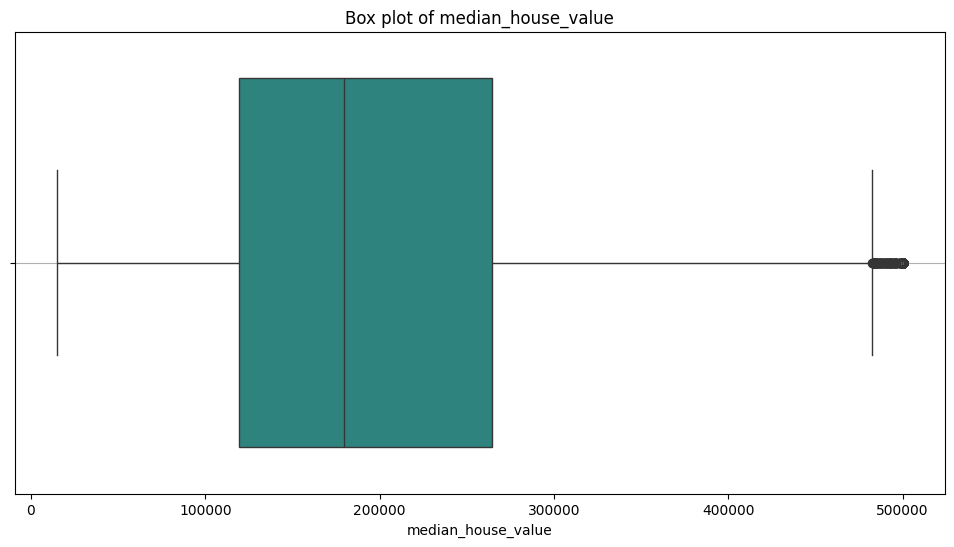

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


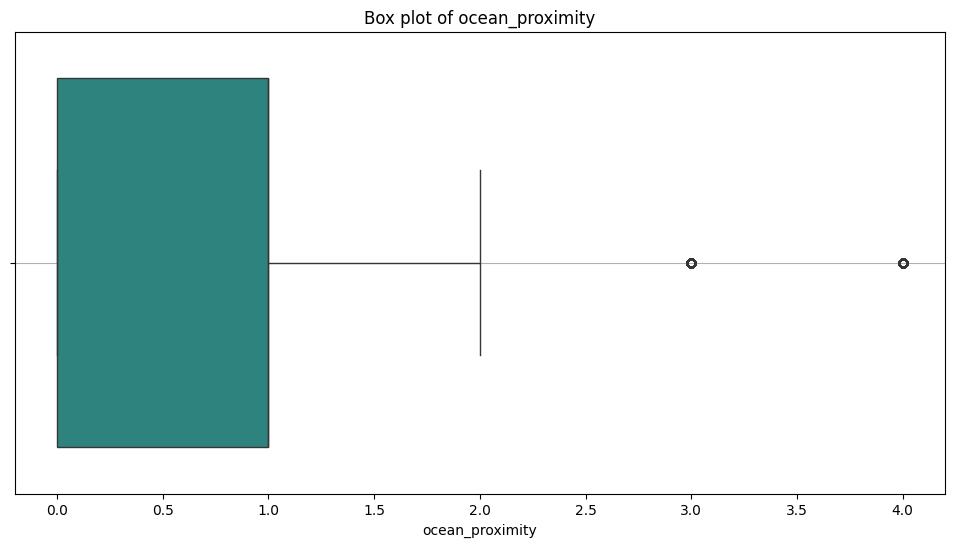

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


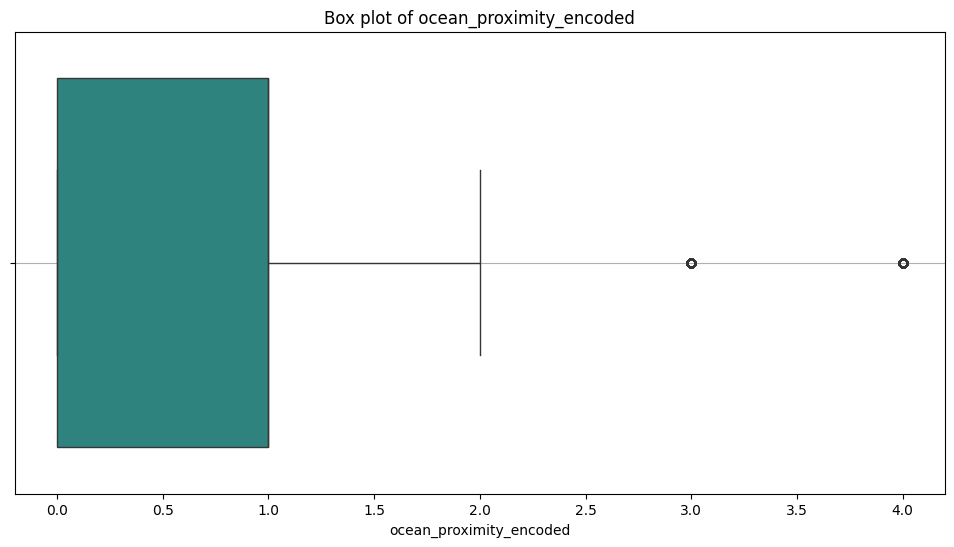

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


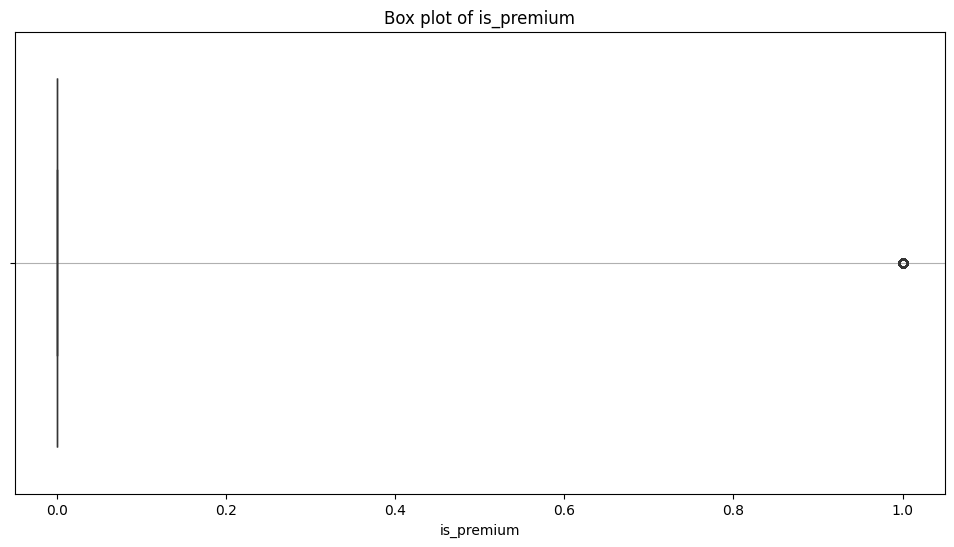

/tmp/ipython-input-3838295495.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)


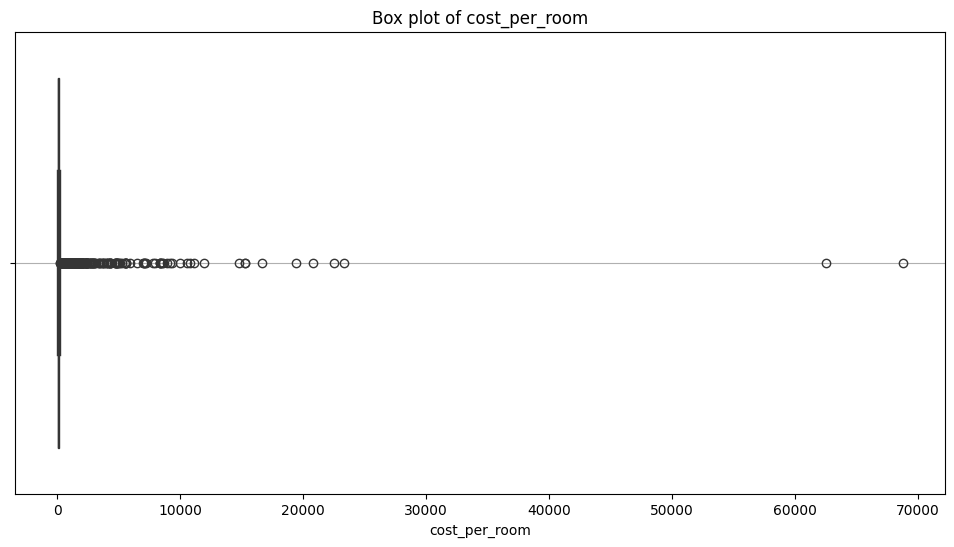

In [91]:
# Q11b
num_cols = data.select_dtypes(include="number").columns
for i in num_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data[i], orient="h",palette='viridis',legend=False)
    plt.title("Box plot of "+i)
    plt.grid(axis='y')
    plt.show()

Q11c

**Strong predictor:** median_income shows the strongest positive correlation with median_house_value, highlighting its predictive significance for housing prices.

**Multicollinearity risk:** Features like total_rooms, total_bedrooms, population, and households exhibit very high inter-correlations (≈0.86–0.97), suggesting redundant information and potential instability in regression models.

**Distribution challenges:** Skewed distributions and outliers in count-based features (e.g., total_rooms, population) suggest the need for transformation techniques (e.g., log-scaling or robust scalers) to improve model robustness and reduce sensitivity to extreme values.

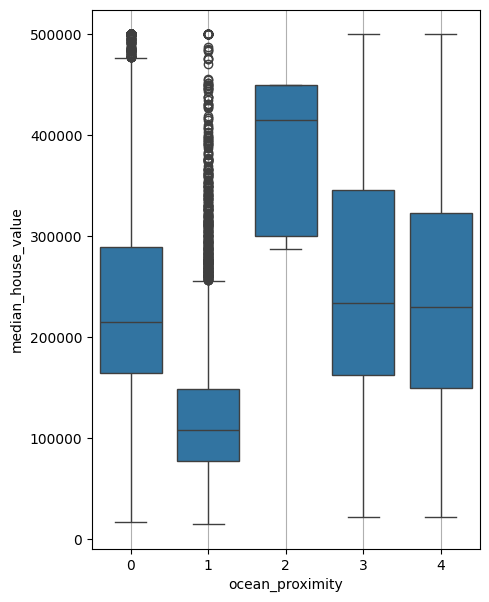

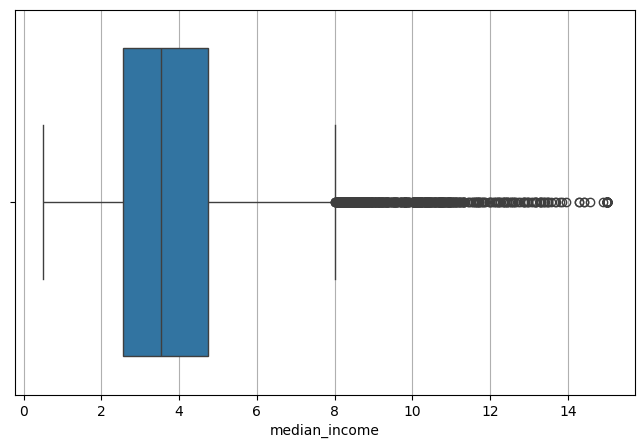

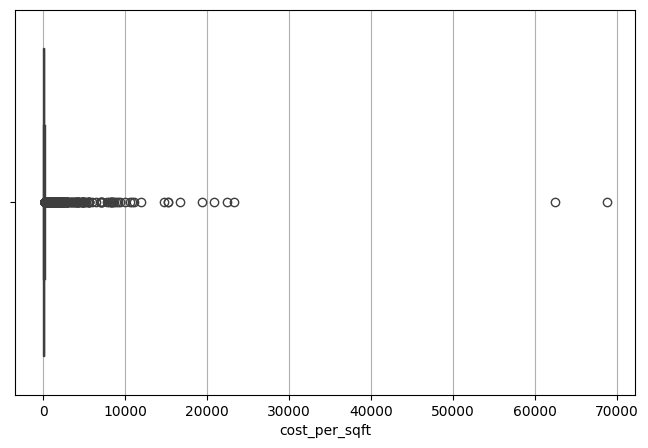

In [92]:
#Q11d and Q11e
plt.figure(figsize=(5,7))
sns.boxplot(x="ocean_proximity", y="median_house_value", data=data)
plt.grid(axis='x')
plt.show()

sns.boxplot(x=data["median_income"], data=data)
plt.grid(axis='x')
plt.show()

#Assume if we dont have the area
data["cost_per_sqft"] = data["median_house_value"]/data["total_rooms"]
sns.boxplot(x=data.cost_per_sqft, data=data)
plt.grid(axis='x')
plt.show()

/tmp/ipython-input-1417710672.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(series_by_cat, labels=categories)
/tmp/ipython-input-1417710672.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(series_by_cat, labels=categories)


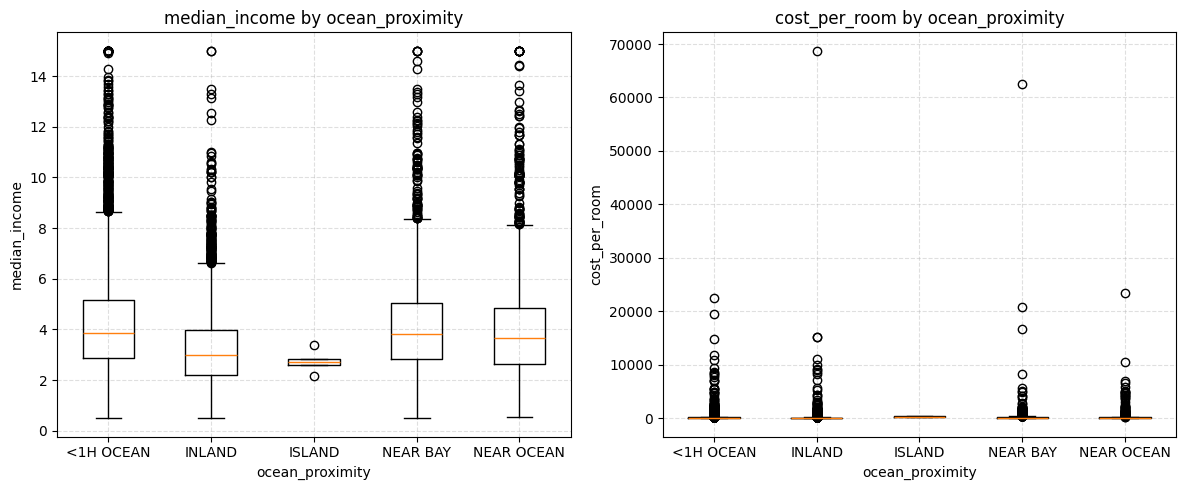

In [65]:
# Q11d and Q11e extension
if 'median_house_value' in data.columns:
    premium_threshold = data['median_house_value'].quantile(0.9)
    data['is_premium'] = (data['median_house_value'] >= premium_threshold).astype(int)
    if 'total_rooms' in data.columns:
        data['cost_per_room'] = data['median_house_value'] / data['total_rooms'].replace(0, np.nan)
    features_to_compare = []
    if 'median_income' in data.columns: features_to_compare.append('median_income')
    if 'cost_per_room' in data.columns: features_to_compare.append('cost_per_room')
    if 'ocean_proximity' in data.columns and features_to_compare:
        import numpy as np
        fig, axes = plt.subplots(1, len(features_to_compare), figsize=(6*len(features_to_compare), 5))
        if len(features_to_compare)==1: axes=[axes]
        categories = sorted(data['ocean_proximity'].unique())
        for ax, feat in zip(axes, features_to_compare):
            series_by_cat = [data.loc[data['ocean_proximity']==cat, feat].dropna() for cat in categories]
            ax.boxplot(series_by_cat, labels=categories)
            ax.set_title(f"{feat} by ocean_proximity"); ax.set_xlabel('ocean_proximity'); ax.set_ylabel(feat)
            ax.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout(); plt.show()

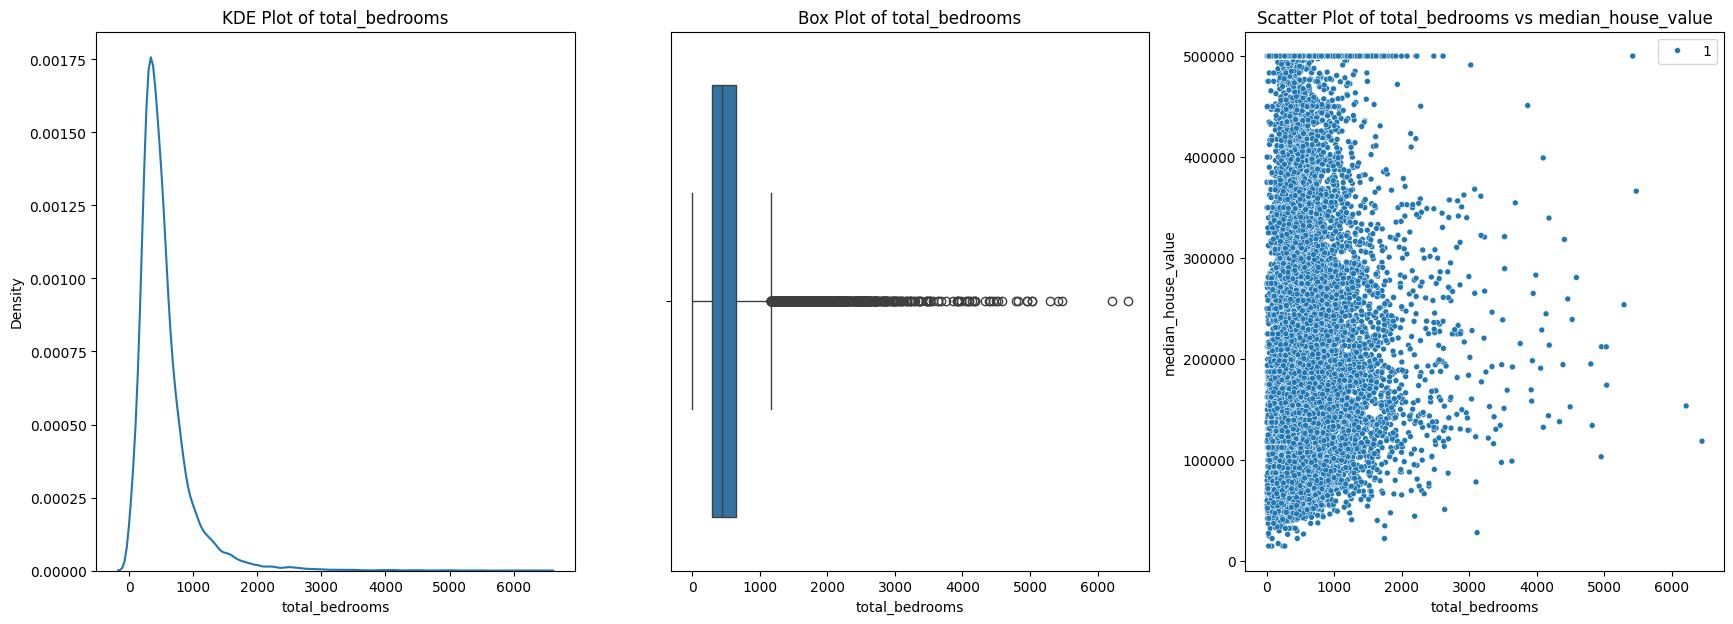

In [93]:
#Q11f
def distribution(col):
    fig,ax = plt.subplots(1,3,figsize=(21,7))
    sns.kdeplot(data[col],ax=ax[0])
    sns.boxplot(x=data[col],ax=ax[1])
    sns.scatterplot(x=data[col],y=data.median_house_value,ax=ax[2],size=1)
    ax[0].set_title("KDE Plot of "+col)
    ax[1].set_title("Box Plot of "+col)
    ax[2].set_title("Scatter Plot of "+col+" vs median_house_value")
    plt.show()

distribution("total_bedrooms")

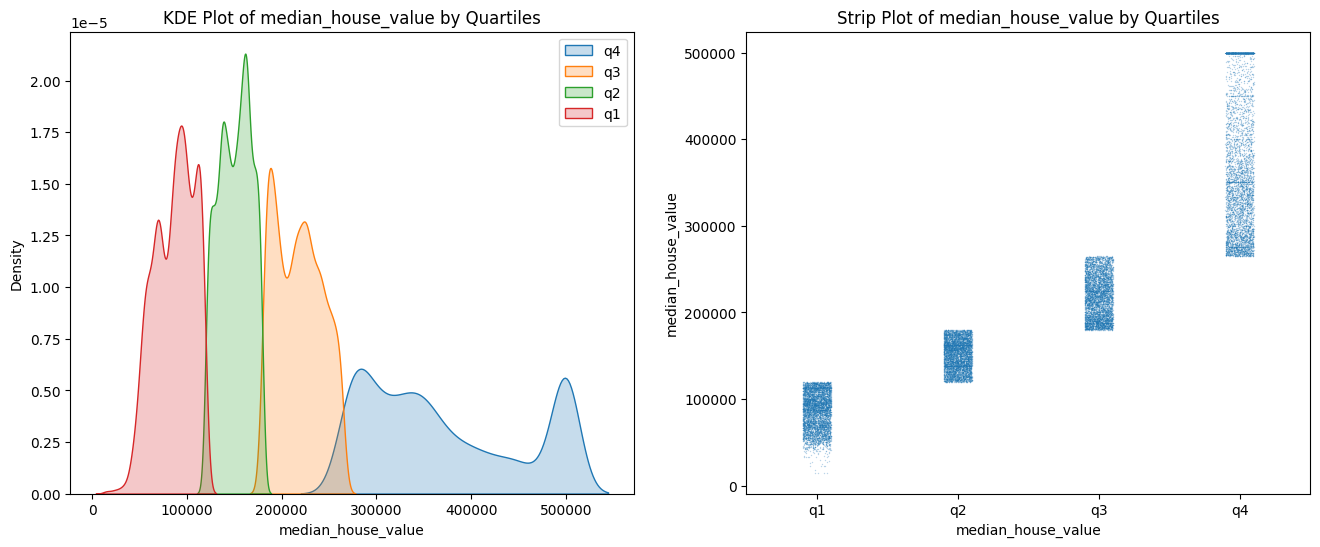

In [94]:
# Q11g
def quartiles(target = "median_house_value"):
    q = pd.qcut(data[target],q=4,labels=["q1","q2","q3","q4"])
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    for i in q.unique():
        sns.kdeplot(data.loc[q==i,target],label=i,ax=ax[0],fill=True)
    sns.stripplot(x=q,y=data[target],ax=ax[1],alpha=0.3,size=1)
    ax[0].legend()
    ax[0].set_title("KDE Plot of "+target+" by Quartiles")
    ax[1].set_title("Strip Plot of "+target+" by Quartiles")
quartiles()

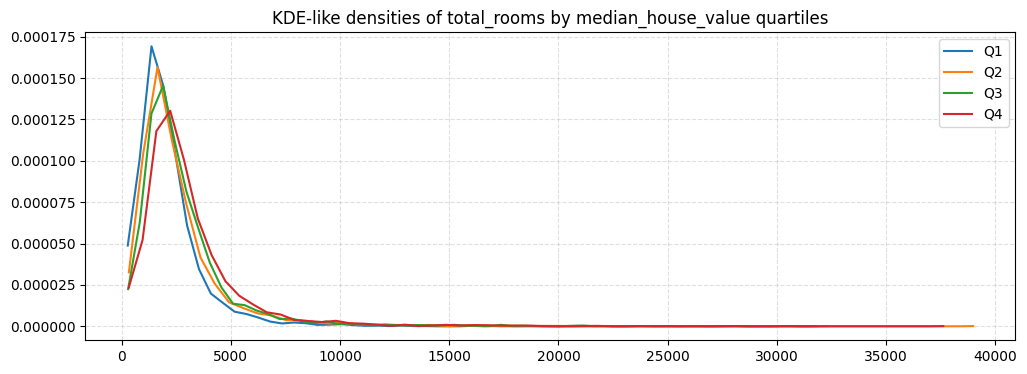

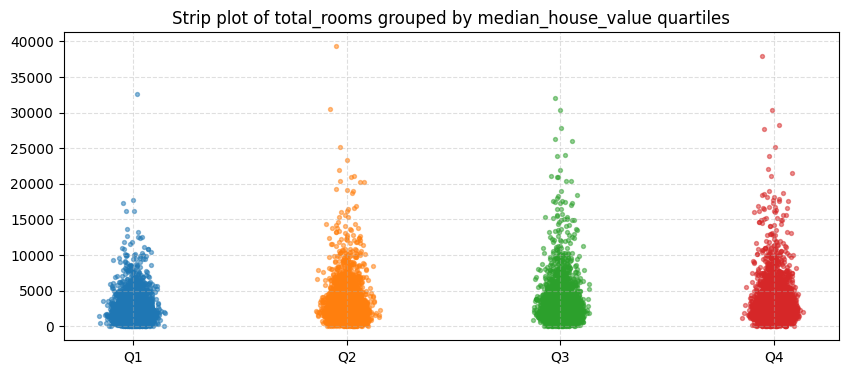

In [103]:
#Q11g extras
def quartile_kde_and_strip(df, num_col, target='median_house_value', bins=60, bandwidth=1.0):
    import numpy as np, matplotlib.pyplot as plt
    if target not in df.columns or num_col not in df.columns:
        print("Required columns not found."); return
    q = df[target].quantile([0.25, 0.5, 0.75]).values
    def qlabel(v):
        if v <= q[0]: return 'Q1'
        elif v <= q[1]: return 'Q2'
        elif v <= q[2]: return 'Q3'
        else: return 'Q4'
    qlabels = df[target].apply(qlabel)
    plt.figure(figsize=(12,4))
    for label in ['Q1','Q2','Q3','Q4']:
        vals = df.loc[qlabels==label, num_col].values.astype(float)
        centers, dens = smooth_density(vals, bins=bins, bandwidth=bandwidth)
        if centers is not None: plt.plot(centers, dens, label=label)
    plt.title(f"KDE-like densities of {num_col} by {target} quartiles")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.4); plt.show()
    # Strip/jitter plot
    plt.figure(figsize=(10,4)); cats = ['Q1','Q2','Q3','Q4']
    for i, label in enumerate(cats):
        vals = df.loc[qlabels==label, num_col].values.astype(float)
        x = np.random.normal(i+1, 0.04, size=len(vals))
        plt.scatter(x, vals, s=8, alpha=0.5)
    plt.xticks(range(1,5), cats); plt.title(f"Strip plot of {num_col} grouped by {target} quartiles")
    plt.grid(True, linestyle='--', alpha=0.4); plt.show()

num_col_example = 'total_rooms' if 'total_rooms' in data.columns else data.select_dtypes(include=np.number).columns[0]
quartile_kde_and_strip(data, num_col_example)

Number of outliers in median_house_value : 1383


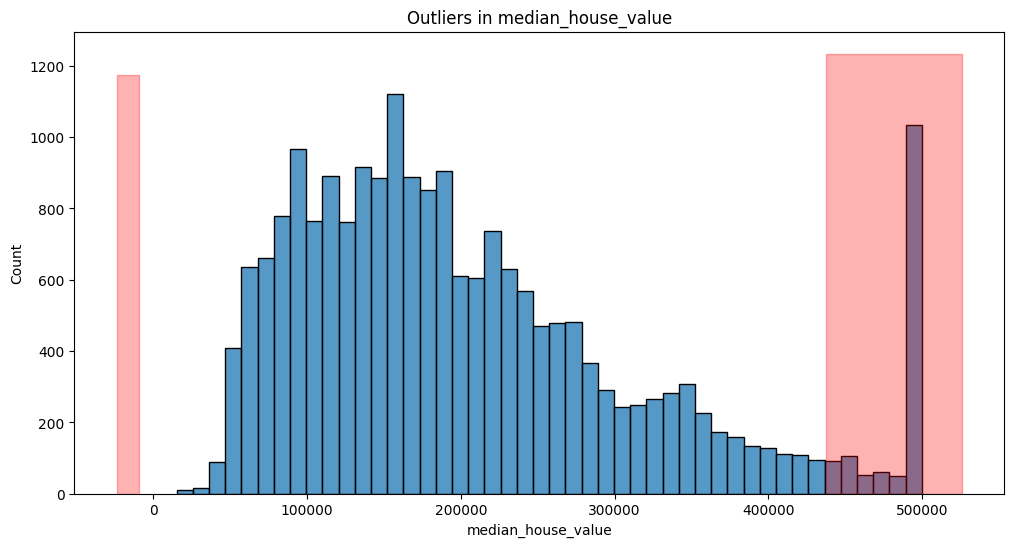

In [95]:
#Q11h
col = "median_house_value"
m = data[col].mean()
s = data[col].std()
lower_bound = m - 2*s
upper_bound = m + 2*s
outliers = data[(data[col]<lower_bound) | (data[col]>upper_bound)]
print("Number of outliers in",col,":",outliers.shape[0])

plt.figure(figsize=(12,6))
sns.histplot(data[col])
plt.fill_between(x=[plt.xlim()[0],lower_bound],y1=plt.ylim()[0],y2=plt.ylim()[1],color="red",alpha=0.3)
plt.fill_between(x=[plt.xlim()[1],upper_bound],y1=plt.ylim()[0],y2=plt.ylim()[1],color="red",alpha=0.3)
plt.title("Outliers in "+col)
plt.show()

In [101]:
#Q11i
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PowerTransformer, MinMaxScaler, StandardScaler
X = data.drop("median_house_value", axis=1)
sc_mm = MinMaxScaler().fit_transform(X)
sc_std = StandardScaler().fit_transform(X)
sc_rob = RobustScaler().fit_transform(X)
sc_qt = QuantileTransformer().fit_transform(X)
sc_pow = PowerTransformer().fit_transform(X)

data_ = data.copy()
X = data_.drop(columns=['median_house_value']) if 'median_house_value' in data_.columns else data_.copy()
X_num = X.select_dtypes(include=np.number).copy()

def summarize_scaled(name, X_scaled):
    df = pd.DataFrame(X_scaled, columns=X_num.columns)
    rng = df.agg(['min','max']).T
    display(rng.style.set_caption(f"{name} ranges (min/max)"))

summarize_scaled("StandardScaler", StandardScaler().fit_transform(X_num))
summarize_scaled("MinMaxScaler", MinMaxScaler().fit_transform(X_num))
summarize_scaled("RobustScaler", RobustScaler().fit_transform(X_num))
summarize_scaled("QuantileTransformer (uniform)", QuantileTransformer(output_distribution='uniform', random_state=42).fit_transform(X_num))
summarize_scaled("PowerTransformer (Yeo-Johnson)", PowerTransformer(standardize=True).fit_transform(X_num))

print("Original range:", (X.min().min(), X.max().max()))
print("MinMax range  :", (sc_mm.min(), sc_mm.max()))
print("Std range     :", (sc_std.min(), sc_std.max()))
print("Robust range  :", (sc_rob.min(), sc_rob.max()))
print("Quantile range:", (sc_qt.min(), sc_qt.max()))
print("Power range   :", (sc_pow.min(), sc_pow.max()))

,min,max
Columns,,
longitude,-2.385992,2.625280
latitude,-1.447568,2.958068
housing_median_age,-2.196180,1.856182
total_rooms,-1.207283,16.815580
total_bedrooms,-1.280530,14.089538
population,-1.256123,30.250330
households,-1.303984,14.601520
median_income,-1.774299,5.858286
ocean_proximity,-0.820653,1.995003


,min,max
Columns,,
longitude,0.000000,1.000000
latitude,0.000000,1.000000
housing_median_age,0.000000,1.000000
total_rooms,0.000000,1.000000
total_bedrooms,0.000000,1.000000
population,0.000000,1.000000
households,0.000000,1.000000
median_income,0.000000,1.000000
ocean_proximity,0.000000,1.000000


,min,max
Columns,,
longitude,-1.546174,1.102902
latitude,-0.455026,2.034392
housing_median_age,-1.473684,1.210526
total_rooms,-1.249816,21.875018
total_bedrooms,-1.262094,17.348736
population,-1.239872,36.797441
households,-1.255385,17.455385
median_income,-1.392252,5.259674
ocean_proximity,-1.000000,3.000000


,min,max
Columns,,
longitude,0.000000,1.000000
latitude,0.000000,1.000000
housing_median_age,0.000000,1.000000
total_rooms,0.000000,1.000000
total_bedrooms,0.000000,1.000000
population,0.000000,1.000000
households,0.000000,1.000000
median_income,0.000000,1.000000
ocean_proximity,0.000000,1.000000


,min,max
Columns,,
longitude,-0.000000,0.000000
latitude,-1.815994,2.081529
housing_median_age,-2.495561,1.761010
total_rooms,-4.907908,5.684875
total_bedrooms,-4.595727,5.255238
population,-4.528522,7.450619
households,-4.403335,5.439466
median_income,-3.446085,3.146571
ocean_proximity,-1.037419,1.505310


Original range: (-124.35, 68750.0)
MinMax range  : (np.float64(0.0), np.float64(1.0))
Std range     : (np.float64(-2.3859923416733877), np.float64(119.41910318829312))
Robust range  : (np.float64(-2.4935585309601387), np.float64(1455.1160589513674))
Quantile range: (np.float64(0.0), np.float64(1.0))
Power range   : (np.float64(-6.437977309304264), np.float64(7.450619018277825))


**When to Prefer Over StandardScaler/MinMaxScaler**

**Outliers and heavy tails:** RobustScaler leverages medians and the interquartile range, ensuring that extreme values do not disproportionately influence scaling. This provides greater robustness under data contamination than StandardScaler or MinMaxScaler.

**Non-Gaussian or skewed distributions:** PowerTransformer mitigates skewness and approximates normality, making it more suitable for algorithms sensitive to Gaussian-like assumptions—an area where StandardScaler falls short.

**Rank-based normalization:** QuantileTransformer enforces a target distribution (uniform or normal) regardless of the original feature shape, harmonizing heterogeneous features and compressing long tails. Unlike MinMaxScaler, it avoids undue compression driven by single extreme values.

**Conceptual Distinctions**

**Affine transformations:** StandardScaler, MinMaxScaler, and RobustScaler apply linear rescaling, preserving relative distances and correlations.

**Nonlinear transformations:** QuantileTransformer and PowerTransformer fundamentally reshape distributions, potentially altering distances and correlations to achieve more stable and well-behaved feature representations.

In [99]:
#Q11j
#People per household
data["people_per_household"] = data["population"] / data["households"]
#Income per person
data["income_per_person"] = data["median_income"] / data["people_per_household"]
#Cost per room
data["cost_per_room"] = data["median_house_value"] / data["total_rooms"]

In [100]:
display(data)

Columns,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded,is_premium,cost_per_room,cost_per_sqft,people_per_household,income_per_person
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3,3,1.0,514.318182,514.318182,2.555556,3.257687
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3,3,0.0,50.500070,50.500070,2.109842,3.934608
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3,3,0.0,240.013633,240.013633,2.802260,2.589838
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3,3,0.0,267.896389,267.896389,2.547945,2.214765
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,3,0.0,210.325753,210.325753,2.181467,1.763125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1,1,0.0,46.906907,46.906907,2.560606,0.609348
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1,1,0.0,110.616930,110.616930,3.122807,0.818751
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1,1,0.0,40.949423,40.949423,2.325635,0.730983
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1,1,0.0,45.537634,45.537634,2.123209,0.879423
